# Graph Analytics: Project

-------------------------------------------------

#### 2021/2022
#### Lorenzo Pigozzi

Note: explore https://pm4py.fit.fraunhofer.de/

In [2]:
# importing the libraries
import pandas as pd
import numpy as np 
import networkx as nx
import itertools
import collections
import random
import matplotlib.pyplot as plt
# network related libraries
# import pm4py
# import pycelonis
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

## 1. Importing the data

In [28]:
# importing the datasets
brazil = pd.read_csv('ACTIVITY_TABLE_BR.csv')
# germany = pd.read_csv('ACTIVITY_TABLE_DE.csv')
# portugal = pd.read_csv('ACTIVITY_TABLE_PT.csv')
# thailand = pd.read_csv('ACTIVITY_TABLE_TH.csv')

In [29]:
# to remove in future
df = brazil.copy()

In [30]:
df.head()

,ACTIVITY,TIMESTAMP,SALES_DOC,SALES_DOC_ITEM,COUNTRY
0,Create Sales Order,2021-10-04 16:22:36,50043243,10,BR
1,Create Sales Order Item,2021-10-04 16:22:36,50043243,10,BR
2,Material Availability Date passed,2021-10-04 00:00:00,50043243,10,BR
3,Create Sales Order,2021-10-04 16:22:36,50043243,20,BR
4,Create Sales Order Item,2021-10-04 16:22:36,50043243,20,BR


In [31]:
df.shape

(1837252, 5)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837252 entries, 0 to 1837251
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   ACTIVITY        object
 1   TIMESTAMP       object
 2   SALES_DOC       int64 
 3   SALES_DOC_ITEM  int64 
 4   COUNTRY         object
dtypes: int64(2), object(3)
memory usage: 70.1+ MB


## 2. Data exploration

In [32]:
# changing data type for SO number and Item number
df['SALES_DOC'] = df['SALES_DOC'].astype(str)
df['SALES_DOC_ITEM'] = df['SALES_DOC_ITEM'].astype(str)

In [33]:
# creating the CASE KEY, combination of Sales Order and item
df['CASE_KEY'] = df['SALES_DOC'] + df['SALES_DOC_ITEM']

In [11]:
# number of distinct SO in the log
print('Number of distinct SO in the log: ', len(df['SALES_DOC'].unique()))

Number of distinct SO in the log:  90205


In [12]:
# number of distinct cases in the log
print('Number of distinct cases in the log: ', len(df['CASE_KEY'].unique()))

Number of distinct cases in the log:  365032


In [92]:
# list of distinct activities
df['ACTIVITY'].unique()

array(['Create Sales Order', 'Create Sales Order Item',
       'Material Availability Date passed', 'Create Picking',
       'Change Inco Terms (Part 2)', 'Create Invoice',
       'Create Invoice cancellation', 'Set Reason for Rejection',
       'Change Price', 'Change Requested Quantity',
       'Customer Acceptance (L650)', 'Clear Invoice',
       'Create Returns delivery for order', 'Record Return Goods Receipt',
       'Create Credit memo', 'Create Delivery', 'Record Goods Issue',
       'Cancel Goods Issue', 'Change Material Availability Date',
       'Change Requested Goods Issue Date', 'Change Inco Terms (Part 1)',
       'Change Payment Terms', 'Change Confirmed Quantity',
       'Create Pro forma invoice', 'Cancel Reason for Rejection',
       'Change Confirmed Goods Issue Date',
       'Create Credit memo cancellation', 'Create Purchase Order',
       'Change Confirmed Delivery Date', 'Clear Credit Memo',
       'Set Initial Delivery Block', 'Change Requested Delivery Date',


## 3. Data Engineering

#### 3.1. Weight calculation

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837252 entries, 0 to 1837251
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   ACTIVITY        object
 1   TIMESTAMP       object
 2   SALES_DOC       object
 3   SALES_DOC_ITEM  object
 4   COUNTRY         object
 5   CASE_KEY        object
dtypes: object(6)
memory usage: 84.1+ MB


In [35]:
## to obtain the weights of the graph, it is necessary to engineer and make calculation for the time

# changing the date type
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')

# calculating the time difference after sorting by timestamp and grouping by CASE_KEY
# df['diff'] = df.sort_values('TIMESTAMP', ascending = True).groupby('CASE_KEY')['TIMESTAMP'].diff()

df['diff'] = df.sort_values(['TIMESTAMP', 'ACTIVITY'], ascending = True).groupby('CASE_KEY')['TIMESTAMP'].diff()

In [36]:
# weight_hour: getting the difference in seconds and dividing for 3600 to get the number of hours
# 3600 seconds = 1 hour
df['weight_hour'] = df['diff'].dt.total_seconds() / 3600

In [37]:
# dropping unnecessary columns
df.drop(columns=['SALES_DOC', 'SALES_DOC_ITEM', 'diff'], inplace = True)

# resetting the index
df = df.sort_values(['CASE_KEY', 'TIMESTAMP', 'ACTIVITY'], ascending = True).reset_index(drop = True)

backup = df.copy()
# df = backup.copy()

#### 3.2. Source and Target creation

In [43]:
## creating Source: 
# appending previous activity in subsequent row after aggregation by case_key and sorting by timestamp
source = ['']
for i in range(1, max(df.index)+1):
    source.append(df['ACTIVITY'][i-1])

df['Source'] = source

In [51]:
# filtering the notnull weight_hour (NaN in case it is the first occurence grouped by case_key)
final_log = df[df['weight_hour'].notnull()]

In [54]:
# dropping and renaming columns
final_log = final_log[['Source', 'ACTIVITY', 'weight_hour']]
final_log.columns = ['Source', 'Target', 'weight']

In [63]:
## aggregaating all cases by source and target and calculating median of the aggregation
# Note: chosing median because it is not affected by outliers
final_log = final_log.groupby(['Source', 'Target']).median('weight').reset_index(drop=False)

In [68]:
# keeping the index as edge identifier (combination of 2 linked activities)
final_log.reset_index(inplace = True)
# renaming columns
final_log.columns = ['index', 'source', 'target', 'weight']
final_log.head()

In [75]:
final_log

,index,source,target,weight
0,0,Cancel Goods Issue,Cancel Goods Issue,0.000000
1,1,Cancel Goods Issue,Change Payment Terms,0.020139
2,2,Cancel Goods Issue,Change Price,0.010000
3,3,Cancel Goods Issue,Create Invoice,0.014028
4,4,Cancel Goods Issue,Record Goods Issue,0.060833
...,...,...,...,...
572,572,Set Reason for Rejection,Create Picking,581.767500
573,573,Set Reason for Rejection,Create Returns delivery for order,2.524167
574,574,Set Reason for Rejection,Create Sales Order Item,0.099722
575,575,Set Reason for Rejection,Material Availability Date passed,1374.406667


## 4. Graph Analytics

In [76]:
# creating a graph with the dataframe engineered
G_dir = nx.from_pandas_edgelist(
    final_log,
    edge_key="index",
    edge_attr=["weight"],
    create_using=nx.DiGraph(),
)

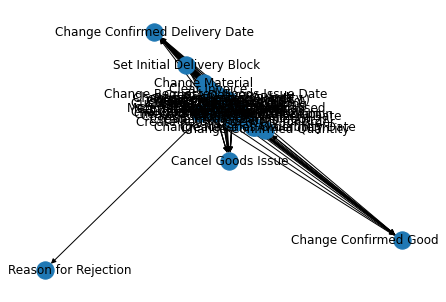

In [77]:
# plotting the graph
nx.draw(G_dir,with_labels = True)

#### 4.1. Variant Explorer

In [89]:
df['ACTIVITY'].value_counts()

Create Sales Order                   365032
Create Sales Order Item              365032
Material Availability Date passed    345194
Create Invoice                       132929
Change Inco Terms (Part 2)           119269
Create Picking                       112369
Record Goods Issue                    84433
Create Delivery                       81096
Clear Invoice                         55069
Set Reason for Rejection              28599
Change Material Availability Date     21228
Change Requested Quantity             13996
Change Requested Goods Issue Date     12763
Change Payment Terms                  11662
Change Price                          10224
Create Credit memo                    10142
Change Confirmed Goods Issue Date      8463
Change Confirmed Delivery Date         8283
Create Purchase Order                  6901
Record Return Goods Receipt            5456
Create Returns delivery for order      5357
Change Material                        4019
Customer Acceptance (L650)      

In [87]:
# identifying the closure of the process for the happy path
# Clear invoice frquency: 55069
print( 'Considering the : ',( 55069 / len(df['CASE_KEY'].unique()) ) * 100, ' % of the cases')

Considering the :  15.08607464551053  % of the cases
